<a href="https://colab.research.google.com/github/isabel-sha/ml-ai/blob/main/Weekly_Forecast_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Weekly Forecast Model for Open, Closed, and Backlog Incidents in ServiceNow**

**1. Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import lightgbm as lgb
import xgboost as xgb
import time

sns.set_style("whitegrid")

**2. Load Data**

In [2]:
df = pd.read_csv("incident.csv", encoding="ISO-8859-1")

# Convert date columns
date_cols = ['opened', 'closed']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

**3. Aggregate Weekly**

In [3]:
# Week of opened incidents
df['week'] = df['opened'].dt.to_period('W').apply(lambda r: r.start_time)
opened_weekly = df.groupby('week').size().reset_index(name='opened')

# Week of closed incidents (directly using 'closed' field)
df['close_week'] = df['closed'].dt.to_period('W').apply(lambda r: r.start_time if pd.notnull(r) else pd.NaT)
closed_weekly = df.dropna(subset=['close_week']).groupby('close_week').size().reset_index(name='closed')

# Create complete weekly timeline
start_week = min(opened_weekly['week'].min(), closed_weekly['close_week'].min())
end_week = max(opened_weekly['week'].max(), closed_weekly['close_week'].max())
timeline = pd.DataFrame({'week': pd.date_range(start_week, end_week, freq='W-MON')})

timeline = timeline.merge(opened_weekly.rename(columns={'week':'week'}), on='week', how='left')
timeline = timeline.merge(closed_weekly.rename(columns={'close_week':'week'}), on='week', how='left')
timeline.fillna(0, inplace=True)

**4. Calculate Backlog**

In [4]:
current_backlog = df[df['active'] == True].shape[0]

timeline = timeline.sort_values('week').reset_index(drop=True)
timeline['backlog'] = np.nan
anchor_idx = timeline.index[-1]
timeline.loc[anchor_idx, 'backlog'] = current_backlog

for i in range(anchor_idx - 1, -1, -1):
    timeline.loc[i, 'backlog'] = (
        timeline.loc[i + 1, 'backlog']
        - timeline.loc[i + 1, 'opened']
        + timeline.loc[i + 1, 'closed']
    )

# Forward Backlog Calculation
timeline['backlog_forward'] = np.nan
timeline['backlog_forward'].iloc[0] = timeline['backlog'].iloc[0]

for i in range(1, len(timeline)):
    timeline['backlog_forward'].iloc[i] = (
        timeline['backlog_forward'].iloc[i-1]
        + timeline['opened'].iloc[i]
        - timeline['closed'].iloc[i]
    )

# Check Forward vs Actual Current Backlog
forward_last_week = timeline['backlog_forward'].iloc[-1]
actual_current_backlog = df[df['active'] == True].shape[0]

print("Forward Backlog Check")
print("-" * 40)
print(f"Calculated Forward Backlog (Last Week): {int(forward_last_week)}")
print(f"Actual Current Backlog: {int(actual_current_backlog)}")
print(f"Difference: {int(forward_last_week - actual_current_backlog)}")

print("\nFirst 5 Weeks Forward Backlog:")
print(timeline[['week','opened','closed','backlog_forward']].head())

Forward Backlog Check
----------------------------------------
Calculated Forward Backlog (Last Week): 112
Actual Current Backlog: 112
Difference: 0

First 5 Weeks Forward Backlog:
        week  opened  closed  backlog_forward
0 2021-07-12     2.0     1.0              1.0
1 2021-07-19    41.0    12.0             30.0
2 2021-07-26    16.0    15.0             31.0
3 2021-08-02    21.0     7.0             45.0
4 2021-08-09    21.0    16.0             50.0


/tmp/ipython-input-1130981617.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  timeline['backlog_forward'].iloc[0] = timeline['backlog'].iloc[0]
/tmp/ipython-input-1130981617.py:17: SettingWithCopyWarning: 
A value is trying to be set on

**5. Add Holidays**

Holiday Date Check:
                       holiday          ds
0               New Year's Day  2021-01-01
7   Martin Luther King Jr. Day  2021-01-18
1                 Memorial Day  2021-05-31
2             Independence Day  2021-07-05
3                    Labor Day  2021-09-06
..                         ...         ...
50               Christmas Day  2026-12-25
84              Winter Closure  2026-12-28
85              Winter Closure  2026-12-29
86              Winter Closure  2026-12-30
87              Winter Closure  2026-12-31

[88 rows x 2 columns]

Holiday Incidents Table:
                                 holiday  incident_count
0                         New Year's Day               1
1             Martin Luther King Jr. Day               1
2                           Memorial Day               1
3                       Independence Day               0
4                              Labor Day               1
5                           Veterans Day               2
6               

/tmp/ipython-input-1893747537.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='holiday', y='incident_count', data=holiday_incidents_table, palette="viridis")


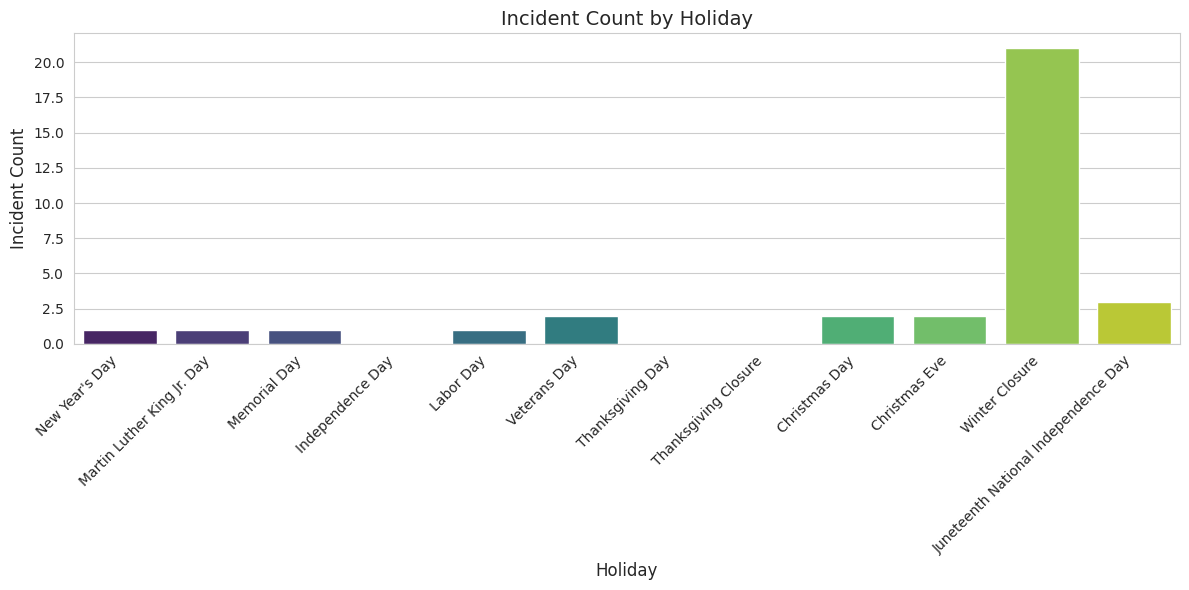

In [5]:
# Set Holidays
years = range(df['opened'].dt.year.min(), df['opened'].dt.year.max() + 2)
us_holidays = holidays.US(years=years, observed=False)

allowed_holidays = {
    "New Year's Day", "Martin Luther King Jr. Day", "Memorial Day",
    "Juneteenth", "Independence Day", "Labor Day", "Veterans Day",
    "Thanksgiving Day", "Christmas Day"
}

def apply_observed(date):
    if date.weekday() == 5:  # Saturday → Friday
        return date - timedelta(days=1)
    elif date.weekday() == 6:  # Sunday → Monday
        return date + timedelta(days=1)
    return date

def previous_weekday(d):
    while d.weekday() >= 5:
        d -= timedelta(days=1)
    return d

def is_weekday(d):
    return d.weekday() < 5

holiday_rows = []

# Juneteenth
for date, name in us_holidays.items():
    if name not in allowed_holidays and "Juneteenth" not in name:
        continue
    if "Juneteenth" in name and date.year < 2023:
        continue
    observed_date = apply_observed(date)
    holiday_rows.append((name, observed_date))

# Thanksgiving Closure (1 day after Thanksgiving Day)
for date, name in us_holidays.items():
    if name == "Thanksgiving Day":
        observed = apply_observed(date)
        closure = apply_observed(observed + timedelta(days=1))
        holiday_rows.append(("Thanksgiving Closure", closure))

# Christmas Eve (1 day before Christmas Day)
for date, name in us_holidays.items():
    if name == "Christmas Day":
        christmas_eve = previous_weekday(date - timedelta(days=1))
        holiday_rows.append(("Christmas Eve", christmas_eve))

# Winter Closure (4 weekdays after Christmas)
for date, name in us_holidays.items():
    if name == "Christmas Day":
        observed = apply_observed(date)
        days_added = 0
        current = observed + timedelta(days=1)
        while days_added < 4:
            if is_weekday(current):
                holiday_rows.append(("Winter Closure", current))
                days_added += 1
            current += timedelta(days=1)

holiday_df = pd.DataFrame(holiday_rows, columns=['holiday','ds']).drop_duplicates()
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 0
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])
holiday_df.sort_values('ds', inplace=True)

# Merge Incidents with Holiday Data (Including Zero Counts)
df['opened'] = pd.to_datetime(df['opened'], errors='coerce')
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'], errors='coerce')

df['opened_date'] = df['opened'].dt.date
holiday_df['ds'] = holiday_df['ds'].dt.date

df_merged = df.merge(holiday_df[['ds', 'holiday']], left_on='opened_date', right_on='ds', how='left')
df_merged['holiday'] = df_merged['holiday'].fillna('Non-Holiday')

# Count Incidents by Holiday (Including Zero Counts)
all_holidays = holiday_df['holiday'].unique()

# Group by 'holiday' and count incidents, ensuring all holidays are included (even with 0 incidents)
holiday_incidents_table = df_merged.groupby('holiday').size().reindex(all_holidays, fill_value=0).reset_index(name='incident_count')

# Print holiday and date check
print("Holiday Date Check:")
print(holiday_df.iloc[:, :2])

# Print the holiday incidents table
print("\nHoliday Incidents Table:")
print(holiday_incidents_table)

# Plot Incidents for Each Holiday
plt.figure(figsize=(12, 6))
sns.barplot(x='holiday', y='incident_count', data=holiday_incidents_table, palette="viridis")

plt.title("Incident Count by Holiday", fontsize=14)
plt.xlabel("Holiday", fontsize=12)
plt.ylabel("Incident Count", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

**6. Feature Engineering**

In [6]:
# Add features
timeline['month'] = timeline['week'].dt.month
timeline['weekday'] = timeline['week'].dt.weekday
timeline['day_of_week'] = timeline['week'].dt.dayofweek
timeline['weekofyear'] = timeline['week'].dt.isocalendar().week
timeline['is_holiday'] = timeline['week'].dt.date.isin(holiday_df['ds']).astype(int)
timeline['is_weekend'] = (timeline['weekday'] >= 5).astype(int)
timeline['is_end_of_month'] = (timeline['weekofyear'].isin([4, 8, 12, 16, 20, 24, 28])).astype(int)

# Cyclical features
timeline['month_sin'] = np.sin(2*np.pi*timeline['month']/12)
timeline['month_cos'] = np.cos(2*np.pi*timeline['month']/12)
timeline['weekday_sin'] = np.sin(2*np.pi*timeline['weekday']/7)
timeline['weekday_cos'] = np.cos(2*np.pi*timeline['weekday']/7)

# Lag and rolling features
timeline = timeline.sort_values('week').reset_index(drop=True)

for lag in [1, 2, 3, 7, 14, 28]:
    timeline[f'opened_lag_{lag}'] = timeline['opened'].shift(lag)
    timeline[f'closed_lag_{lag}'] = timeline['closed'].shift(lag)

for window in [3, 4, 7, 14]:
    timeline[f'opened_roll_{window}'] = timeline['opened'].shift(1).rolling(window).mean()
    timeline[f'closed_roll_{window}'] = timeline['closed'].shift(1).rolling(window).mean()

for window in [3, 7, 14, 28]:
    timeline[f'opened_ewma_{window}'] = timeline['opened'].ewm(span=window, adjust=False).mean()
    timeline[f'closed_ewma_{window}'] = timeline['closed'].ewm(span=window, adjust=False).mean()

for lag1, lag2 in [(1, 3), (1, 7), (3, 14), (7, 28)]:
    timeline[f'opened_lag_{lag1}_lag_{lag2}_diff'] = timeline[f'opened_lag_{lag1}'] - timeline[f'opened_lag_{lag2}']
    timeline[f'closed_lag_{lag1}_lag_{lag2}_diff'] = timeline[f'closed_lag_{lag1}'] - timeline[f'closed_lag_{lag2}']

timeline = timeline.dropna().reset_index(drop=True)

BASE_FEATURES = ['month','weekday','weekofyear','is_holiday', 'is_weekend', 'is_end_of_month','day_of_week']
FEATURE_SETS = {
    'opened': [c for c in timeline.columns if 'lag' in c or 'roll' in c or 'ewma' in c or c in BASE_FEATURES],
    'closed': [c for c in timeline.columns if 'lag' in c or 'roll' in c or 'ewma' in c or c in BASE_FEATURES]
}

print(FEATURE_SETS)

{'opened': ['month', 'weekday', 'day_of_week', 'weekofyear', 'is_holiday', 'is_weekend', 'is_end_of_month', 'opened_lag_1', 'closed_lag_1', 'opened_lag_2', 'closed_lag_2', 'opened_lag_3', 'closed_lag_3', 'opened_lag_7', 'closed_lag_7', 'opened_lag_14', 'closed_lag_14', 'opened_lag_28', 'closed_lag_28', 'opened_roll_3', 'closed_roll_3', 'opened_roll_4', 'closed_roll_4', 'opened_roll_7', 'closed_roll_7', 'opened_roll_14', 'closed_roll_14', 'opened_ewma_3', 'closed_ewma_3', 'opened_ewma_7', 'closed_ewma_7', 'opened_ewma_14', 'closed_ewma_14', 'opened_ewma_28', 'closed_ewma_28', 'opened_lag_1_lag_3_diff', 'closed_lag_1_lag_3_diff', 'opened_lag_1_lag_7_diff', 'closed_lag_1_lag_7_diff', 'opened_lag_3_lag_14_diff', 'closed_lag_3_lag_14_diff', 'opened_lag_7_lag_28_diff', 'closed_lag_7_lag_28_diff'], 'closed': ['month', 'weekday', 'day_of_week', 'weekofyear', 'is_holiday', 'is_weekend', 'is_end_of_month', 'opened_lag_1', 'closed_lag_1', 'opened_lag_2', 'closed_lag_2', 'opened_lag_3', 'closed_la

**7. Train/Test Split**

In [7]:
last_date = timeline['week'].max()
test_start = last_date - pd.Timedelta(days=120)  # ~4 months

train_df = timeline[timeline['week'] < test_start].copy()
test_df  = timeline[timeline['week'] >= test_start].copy()

**8. Feature Selection Function**

In [8]:
def select_best_num_features(target_col, min_features=5, max_features=20, step=1):
    features = FEATURE_SETS[target_col]
    tscv = TimeSeriesSplit(n_splits=5)

    temp_gb = GradientBoostingRegressor(random_state=42, n_estimators=200, max_depth=3)
    temp_gb.fit(train_df[features], train_df[target_col])
    importances = pd.Series(temp_gb.feature_importances_, index=features).sort_values(ascending=False)

    best_mae = float('inf')
    best_features = None

    for n in range(min_features, min(max_features, len(features)) + 1, step):
        selected_features = importances.head(n).index.tolist()
        cv_mae = -cross_val_score(temp_gb, train_df[selected_features], train_df[target_col],
                                  cv=tscv, scoring='neg_mean_absolute_error').mean()
        print(f"Top {n} features → CV MAE: {cv_mae:.3f}")

        if cv_mae < best_mae:
            best_mae = cv_mae
            best_features = selected_features

    print(f"\n✅ Best number of features: {len(best_features)} → CV MAE: {best_mae:.3f}")
    print("Selected Features:", ", ".join(best_features))
    return best_features

**9. Model Metric Functions**

In [9]:
def compute_metrics(name, model, X_train, y_train, X_test, y_test, tscv):
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = np.sqrt(mean_squared_error(y_test, preds))

    cv_scores = -cross_val_score(
        model, X_train, y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    return {
        'model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'CV_MAE': cv_scores.mean(),
        'CV_STD': cv_scores.std()
    }


def naive_metrics(y_train, y_test):
    naive_test_pred = y_test.shift(1).dropna()
    naive_test_actual = y_test.iloc[1:]

    test_mae = mean_absolute_error(naive_test_actual, naive_test_pred)
    test_rmse = np.sqrt(mean_squared_error(naive_test_actual, naive_test_pred))

    naive_train_pred = y_train.shift(1).dropna()
    naive_train_actual = y_train.iloc[1:]
    cv_mae = mean_absolute_error(naive_train_actual, naive_train_pred)

    return {
        'model': 'NAIVE',
        'MAE': test_mae,
        'RMSE': test_rmse,
        'CV_MAE': cv_mae,
        'CV_STD': 0.0
    }

**10. Model Training and Evaluation Function**

In [10]:
def tune_and_evaluate_model(target_col, min_features=5, max_features=20):
    start_time = time.time()

    # Select Features
    selected_features = select_best_num_features(target_col, min_features=min_features, max_features=max_features)

    tscv = TimeSeriesSplit(n_splits=5)

    # Hyperparameter Grids
    rf_param_grid = {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5],
        'max_features': ['sqrt', 'log2', None]
    }

    gb_param_grid = {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10]
    }

    lgb_param_grid = {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'min_child_samples': [10, 20, 30]
    }

    xgb_param_grid = {
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Random Forest
    rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                   rf_param_grid, n_iter=10, cv=tscv,
                                   scoring='neg_mean_absolute_error', n_jobs=-1)
    rf_search.fit(train_df[selected_features], train_df[target_col])

    # Gradient Boosting
    gb_search = RandomizedSearchCV(GradientBoostingRegressor(random_state=42),
                                   gb_param_grid, n_iter=10, cv=tscv,
                                   scoring='neg_mean_absolute_error', n_jobs=-1)
    gb_search.fit(train_df[selected_features], train_df[target_col])

    # LightGBM
    lgb_search = RandomizedSearchCV(lgb.LGBMRegressor(random_state=42),
                                    lgb_param_grid, n_iter=10, cv=tscv,
                                    scoring='neg_mean_absolute_error', n_jobs=-1)
    lgb_search.fit(train_df[selected_features], train_df[target_col])

    # XGBoost
    xgb_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42),
                                    xgb_param_grid, n_iter=10, cv=tscv,
                                    scoring='neg_mean_absolute_error', n_jobs=-1)
    xgb_search.fit(train_df[selected_features], train_df[target_col])

    # Voting
    voting = VotingRegressor([
        ('rf', rf_search.best_estimator_),
        ('gb', gb_search.best_estimator_),
        ('lgb', lgb_search.best_estimator_),
        ('xgb', xgb_search.best_estimator_)
    ])
    voting.fit(train_df[selected_features], train_df[target_col])

    # Stacking
    stacking = StackingRegressor(
        estimators=[
            ('rf', rf_search.best_estimator_),
            ('gb', gb_search.best_estimator_),
            ('lgb', lgb_search.best_estimator_),
            ('xgb', xgb_search.best_estimator_)
        ],
        final_estimator=LinearRegression(),
        n_jobs=-1
    )
    stacking.fit(train_df[selected_features], train_df[target_col])

    # Predictions
    preds = {
        'rf': rf_search.best_estimator_.predict(test_df[selected_features]),
        'gb': gb_search.best_estimator_.predict(test_df[selected_features]),
        'lgb': lgb_search.best_estimator_.predict(test_df[selected_features]),
        'xgb': xgb_search.best_estimator_.predict(test_df[selected_features]),
        'voting': voting.predict(test_df[selected_features]),
        'stacking': stacking.predict(test_df[selected_features])
    }

    # Model Evaluation Table
    models_all = {
        'RF': rf_search.best_estimator_,
        'GB': gb_search.best_estimator_,
        'LGB': lgb_search.best_estimator_,
        'XGB': xgb_search.best_estimator_,
        'VOTING': voting,
        'STACKING': stacking
    }

    metrics = []
    for name, model in models_all.items():
        metrics.append(
            compute_metrics(
                name, model,
                train_df[selected_features],
                train_df[target_col],
                test_df[selected_features],
                test_df[target_col],
                tscv
            )
        )

    # Add Naive Baseline
    metrics.append(
        naive_metrics(train_df[target_col], test_df[target_col])
    )

    metrics_df = pd.DataFrame(metrics)

    metrics_df['MAE_rank'] = metrics_df['MAE'].rank()
    metrics_df['RMSE_rank'] = metrics_df['RMSE'].rank()
    metrics_df['MAPE_rank'] = metrics_df['MAPE'].rank()
    metrics_df['CV_MAE_rank'] = metrics_df['CV_MAE'].rank()
    metrics_df['CV_STD_rank'] = metrics_df['CV_STD'].rank()
    metrics_df['score'] = (
        metrics_df['MAE_rank'] * 0.30 +
        metrics_df['RMSE_rank'] * 0.20 +
        metrics_df['MAPE_rank'] * 0.20 +
        metrics_df['CV_MAE_rank'] * 0.25 +
        metrics_df['CV_STD_rank'] * 0.05
    )

    metrics_df['model'] = metrics_df['model'].apply(lambda x: f"{x} (Baseline)" if x == 'NAIVE' else x)

    best_row = metrics_df.loc[metrics_df['score'].idxmin()]
    best_model_name = best_row['model']
    best_model = models_all.get(best_model_name.replace(" (Baseline)", ""), None)

    training_time = time.time() - start_time

    # Print Results
    print("\n📊 MODEL COMPARISON")
    print(metrics_df.sort_values('score')[['model','MAE','RMSE','MAPE', 'CV_MAE','CV_STD','score']])

    print("\n🏆 BEST MODEL SELECTED")
    print("-" * 40)
    print(f"Target       : {target_col}")
    print(f"Model        : {best_model_name}")
    print(f"MAE          : {best_row['MAE']:.2f}")
    print(f"RMSE         : {best_row['RMSE']:.2f}")
    print(f"CV MAE       : {best_row['CV_MAE']:.2f} ± {best_row['CV_STD']:.2f}")
    print(f"Training Time: {training_time:.1f}s")

    # Print Average Weekly Count
    weekly_counts = df.groupby('week')[target_col].count()
    avg_weekly_count = weekly_counts.mean()
    avg_train = train_df[target_col].mean()
    avg_test = test_df[target_col].mean()
    print(f"\n📈 Average weekly {target_col}: Total = {avg_weekly_count:.2f}, Train = {avg_train:.2f}, Test = {avg_test:.2f}")

    # Plot Actual vs Predicted for Best Model
    y_true = test_df[target_col]
    y_pred = best_model.predict(test_df[selected_features])

    plt.figure(figsize=(12,6))
    plt.plot(test_df['week'], y_true, label='Actual', marker='o')
    plt.plot(test_df['week'], y_pred, label='Predicted', linestyle='--', marker='x')
    plt.xlabel('Week')
    plt.ylabel(target_col.capitalize())
    plt.title(f'{target_col.capitalize()}: Actual vs Predicted (Best Model)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'best_model_name': best_model_name,
        'best_model': best_model,
        'metrics': metrics_df,
        'models': models_all,
        'selected_features': selected_features
    }

**11. Run Open and Close Results**

Top 5 features → CV MAE: 2.240
Top 6 features → CV MAE: 2.368
Top 7 features → CV MAE: 2.365
Top 8 features → CV MAE: 2.494
Top 9 features → CV MAE: 2.540
Top 10 features → CV MAE: 2.413
Top 11 features → CV MAE: 2.444
Top 12 features → CV MAE: 2.515
Top 13 features → CV MAE: 2.537
Top 14 features → CV MAE: 2.609
Top 15 features → CV MAE: 2.583
Top 16 features → CV MAE: 2.573
Top 17 features → CV MAE: 2.661
Top 18 features → CV MAE: 2.649
Top 19 features → CV MAE: 2.749
Top 20 features → CV MAE: 2.837

✅ Best number of features: 5 → CV MAE: 2.240
Selected Features: opened_ewma_3, opened_roll_3, opened_lag_1, closed_roll_3, opened_roll_4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 188, number of used features: 5
[LightGBM] [Info] Start training from score 23.941489
[LightGBM] [Warn

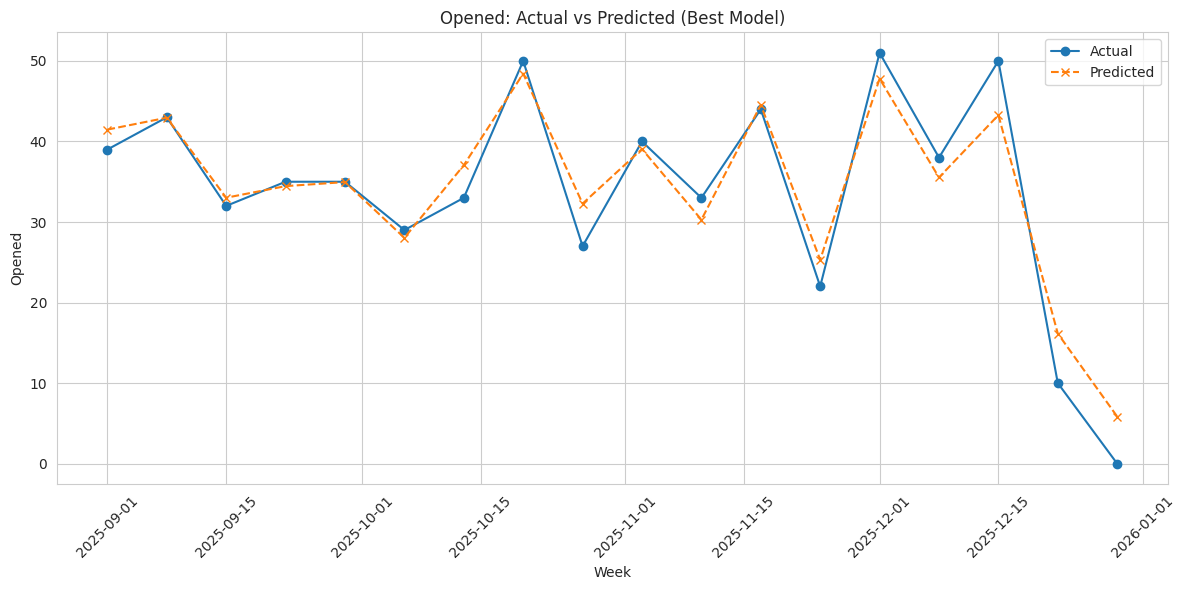

In [11]:
opened_results = tune_and_evaluate_model('opened', min_features=5, max_features=20)

Top 5 features → CV MAE: 3.227
Top 6 features → CV MAE: 3.446
Top 7 features → CV MAE: 3.111
Top 8 features → CV MAE: 3.322
Top 9 features → CV MAE: 3.420
Top 10 features → CV MAE: 3.484
Top 11 features → CV MAE: 3.447
Top 12 features → CV MAE: 3.599
Top 13 features → CV MAE: 3.602
Top 14 features → CV MAE: 3.418
Top 15 features → CV MAE: 3.547
Top 16 features → CV MAE: 3.490
Top 17 features → CV MAE: 3.551
Top 18 features → CV MAE: 3.589
Top 19 features → CV MAE: 3.502
Top 20 features → CV MAE: 3.694

✅ Best number of features: 7 → CV MAE: 3.111
Selected Features: closed_ewma_3, closed_roll_4, closed_roll_3, closed_lag_1, closed_lag_1_lag_7_diff, closed_lag_14, closed_lag_1_lag_3_diff
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 315
[LightGBM] [Info] Number of data points in the train set: 188, number of used features: 7
[LightGBM] [Info] St

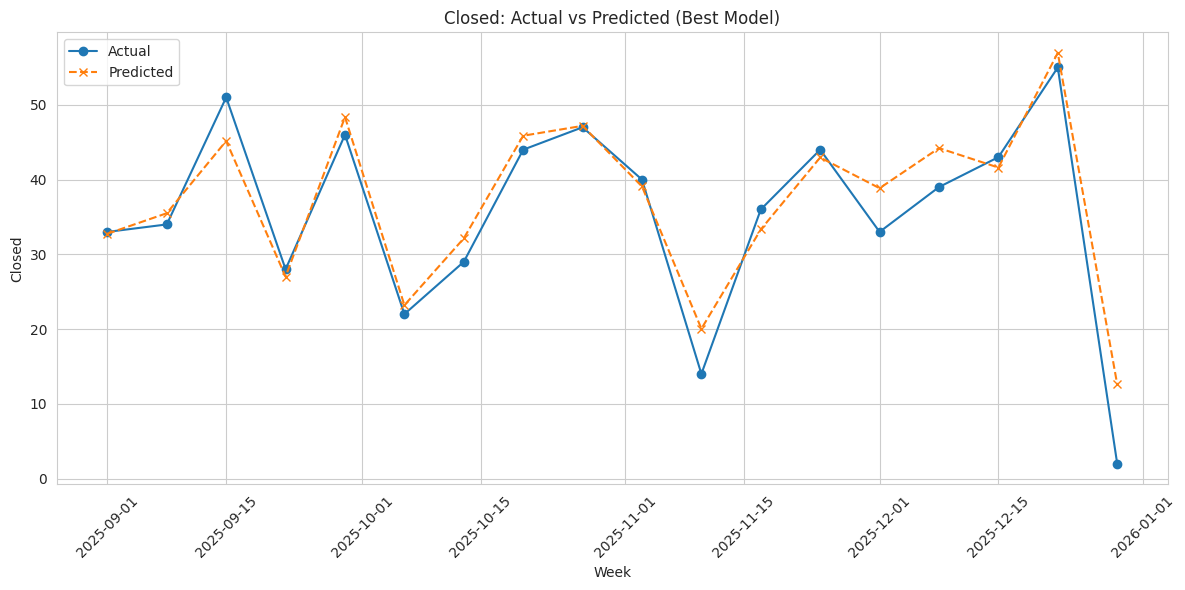

In [12]:
closed_results = tune_and_evaluate_model('closed', min_features=5, max_features=20)

**12. Backlog Predictions Using Best Models**


📦 BACKLOG PREDICTION PERFORMANCE
---------------------------------------------
MAE   : 6.28
RMSE  : 8.85
MBE   : -3.22
MAPE  : 4.67%


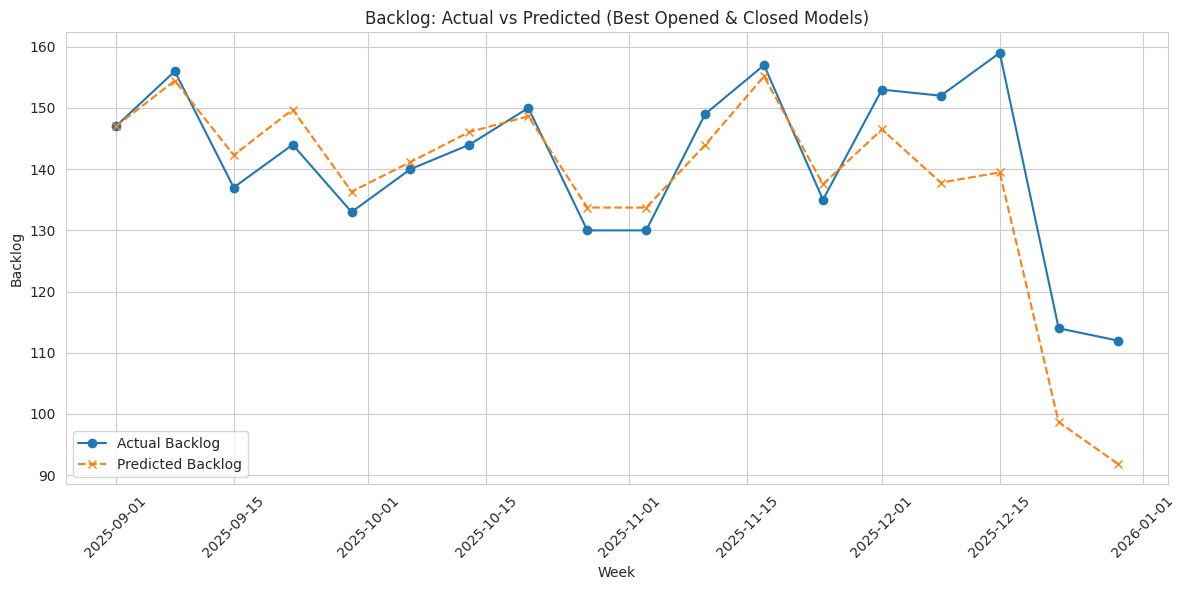

In [13]:
def evaluate_backlog(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mbe = np.mean(predicted - actual)  # bias

    mape = np.mean(
        np.abs((actual - predicted) / np.clip(actual, 1e-6, None))
    ) * 100

    return {
        'Backlog_MAE': mae,
        'Backlog_RMSE': rmse,
        'Backlog_MBE': mbe,
        'Backlog_MAPE_%': mape
    }

opened_model = opened_results['best_model']
closed_model = closed_results['best_model']
opened_features  = opened_results['selected_features']
closed_features = closed_results['selected_features']

timeline_test = test_df.copy()

timeline_test['opened_pred'] = opened_model.predict(
    timeline_test[opened_features]
)

timeline_test['closed_pred'] = closed_model.predict(
    timeline_test[closed_features]
)

timeline_test['backlog_pred'] = np.nan
timeline_test.iloc[0, timeline_test.columns.get_loc('backlog_pred')] = timeline_test.iloc[0]['backlog']

for i in range(1, len(timeline_test)):
    timeline_test.iloc[i, timeline_test.columns.get_loc('backlog_pred')] = (
        timeline_test.iloc[i-1]['backlog_pred']
        + timeline_test.iloc[i]['opened_pred']
        - timeline_test.iloc[i]['closed_pred']
    )

backlog_metrics = evaluate_backlog(
    timeline_test['backlog'],
    timeline_test['backlog_pred']
)

print("\n📦 BACKLOG PREDICTION PERFORMANCE")
print("-" * 45)
print(f"MAE   : {backlog_metrics['Backlog_MAE']:.2f}")
print(f"RMSE  : {backlog_metrics['Backlog_RMSE']:.2f}")
print(f"MBE   : {backlog_metrics['Backlog_MBE']:.2f}")
print(f"MAPE  : {backlog_metrics['Backlog_MAPE_%']:.2f}%")


plt.figure(figsize=(12,6))
plt.plot(timeline_test['week'], timeline_test['backlog'], label='Actual Backlog', marker='o')
plt.plot(timeline_test['week'], timeline_test['backlog_pred'], label='Predicted Backlog', linestyle='--', marker='x')
plt.xlabel("Week")
plt.ylabel("Backlog")
plt.title("Backlog: Actual vs Predicted (Best Opened & Closed Models)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()